In [1]:
source("/root/workspace/code/midas/preprocess/utils.R")
setwd("/root/workspace/code/midas/")

base_dir <- "data/raw/rna+adt/bm"
rna_path <- pj(base_dir, "GSM3681518_MNC_RNA_counts.tsv")
adt_path <- pj(base_dir, "GSM3681519_MNC_ADT_counts.tsv")
hto_path <- pj(base_dir, "GSM3681520_MNC_HTO_counts.tsv")

output_dir <- pj(base_dir, "seurat")
mkdir(output_dir, remove_old = T)

Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: 'S4Vectors'


The following object is masked from 'package:future':

    values


The fol

Removing directory data/raw/rna+adt/bm/seurat


An object of class Seurat 
17008 features across 33454 samples within 1 assay 
Active assay: rna (17008 features, 0 variable features)

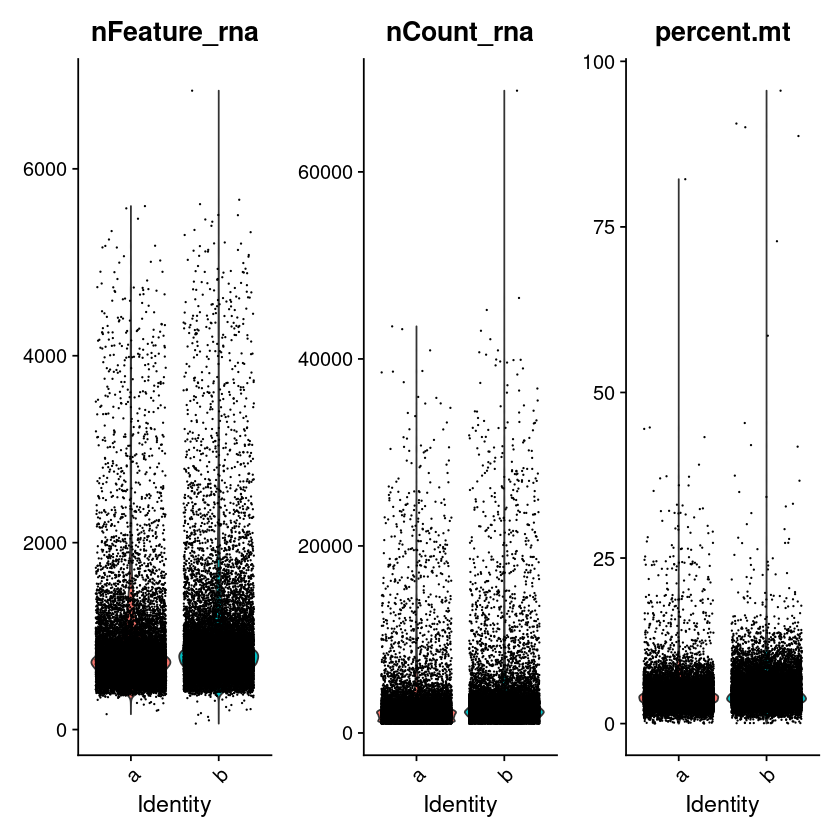

An object of class Seurat 
17008 features across 33281 samples within 1 assay 
Active assay: rna (17008 features, 0 variable features)

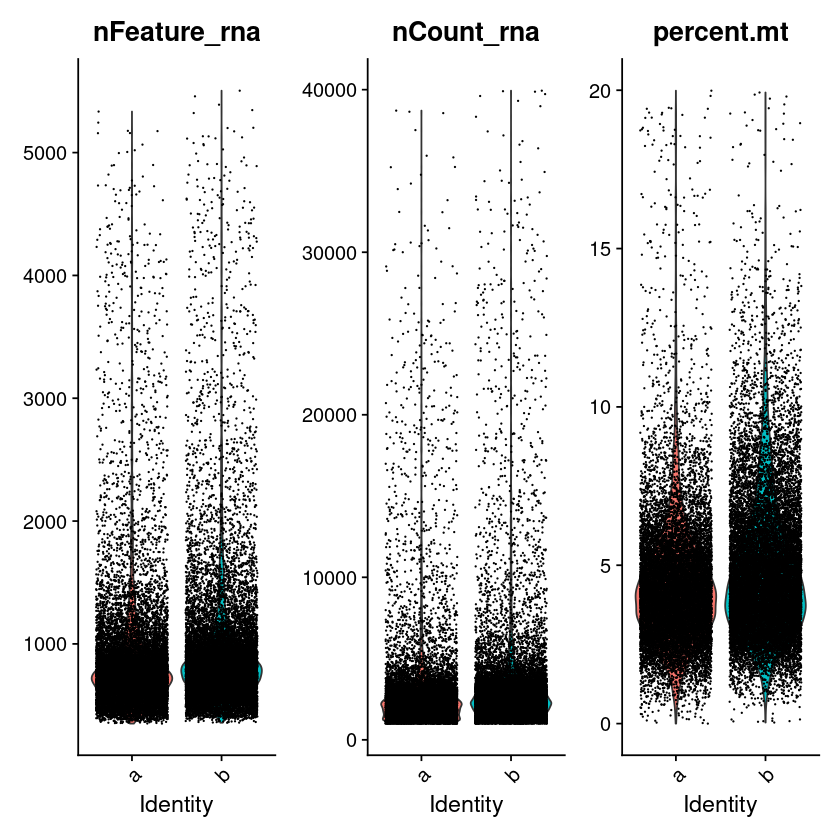

In [2]:
# RNA
# load data
rna_counts <- read.table(file = rna_path, sep = "\t", header = TRUE)
rna <- gen_rna(rna_counts)
VlnPlot(rna, c("nFeature_rna", "nCount_rna", "percent.mt"),
        pt.size = 0.001, ncol = 3, log = F) + NoLegend()
rna
# QC
rna <- subset(rna, subset =
    nFeature_rna > 350 & nFeature_rna < 6000 &
    nCount_rna > 300 & nCount_rna < 40000 &
    percent.mt < 20
)
VlnPlot(rna, c("nFeature_rna", "nCount_rna", "percent.mt"),
        pt.size = 0.001, ncol = 3) + NoLegend()
rna

An object of class Seurat 
25 features across 33454 samples within 1 assay 
Active assay: adt (25 features, 0 variable features)

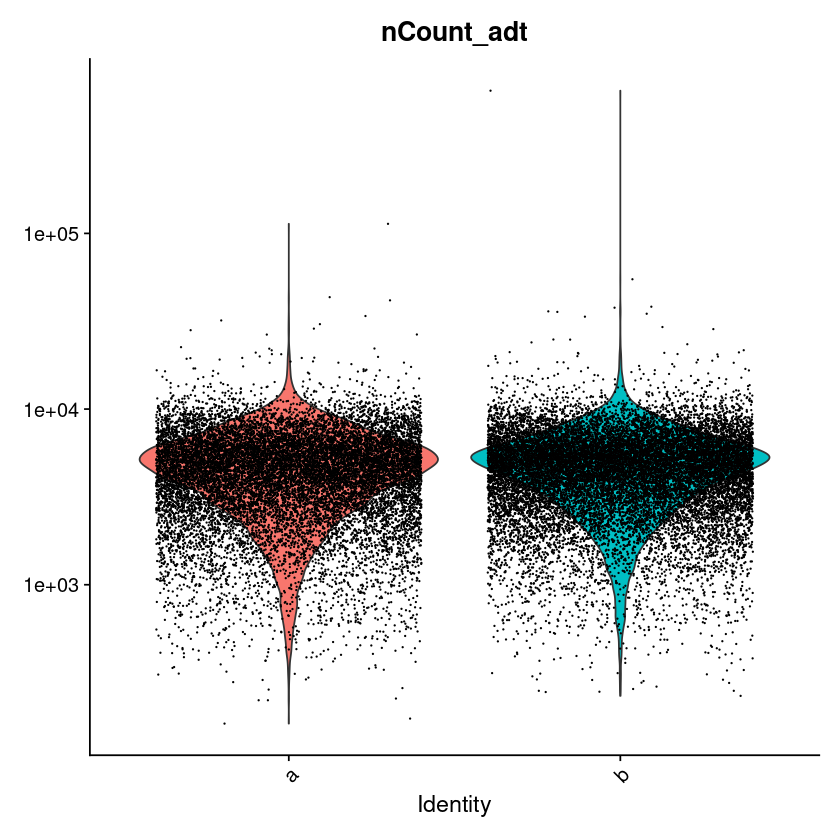

An object of class Seurat 
25 features across 33168 samples within 1 assay 
Active assay: adt (25 features, 0 variable features)

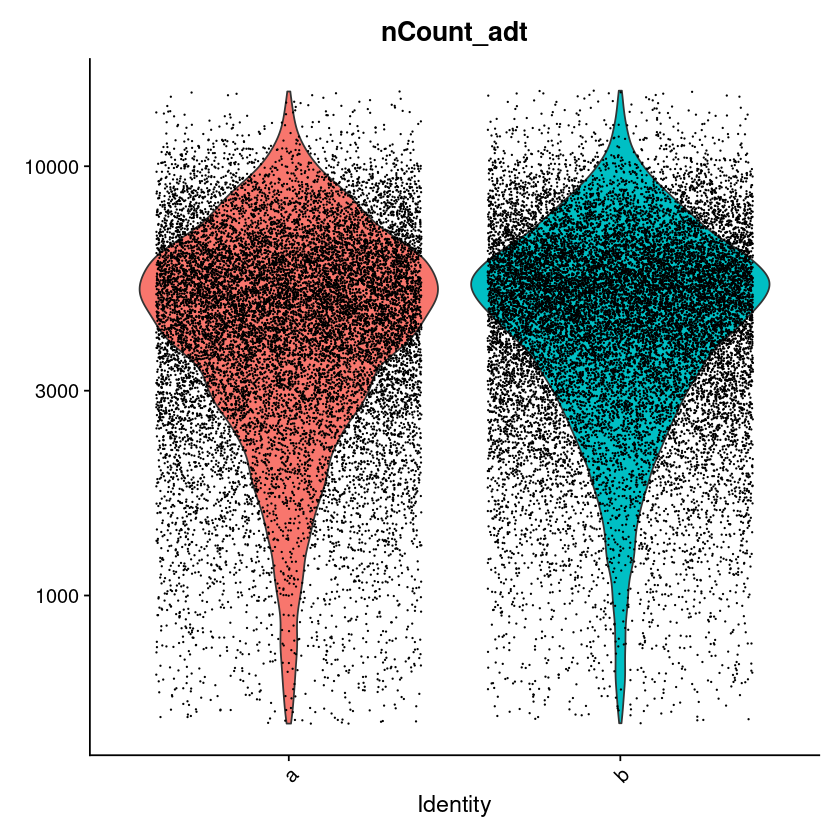

In [3]:
# ADT
# load data
adt_counts <- read.table(file = adt_path, sep = "\t", header = TRUE)
adt_counts <- adt_counts[, colnames(rna_counts)]
adt <- gen_adt(adt_counts)
VlnPlot(adt, c("nCount_adt"), pt.size = 0.001, ncol = 1, log = T) + NoLegend()
adt
# QC
adt <- subset(adt, subset = nCount_adt > 500 & nCount_adt < 15000)
VlnPlot(adt, c("nCount_adt"), pt.size = 0.001, ncol = 1, log = T) + NoLegend()
adt

In [4]:
# HTO
# load data
hto_counts <- read.table(file = hto_path, sep = "\t", header = TRUE)
hto_counts <- hto_counts[, colnames(rna_counts)]
hto <- CreateSeuratObject(counts = hto_counts, assay = "hto")
# remove doublets
hto <- NormalizeData(hto, assay = "hto", normalization.method = "CLR", margin = 1)
hto <- HTODemux(hto, assay = "hto", positive.quantile = 0.99)
table(hto$hto_classification.global)
Idents(hto) <- "hto_classification.global"
hto <- subset(hto, idents = "Singlet")
hto

Cutoff for HumanHTO1 : 109 reads

Cutoff for HumanHTO10 : 69 reads

Cutoff for HumanHTO2 : 95 reads

Cutoff for HumanHTO3 : 109 reads

Cutoff for HumanHTO4 : 59 reads

Cutoff for HumanHTO5 : 123 reads

Cutoff for HumanHTO6 : 89 reads

Cutoff for HumanHTO7 : 96 reads

Cutoff for HumanHTO8 : 104 reads

Cutoff for HumanHTO9 : 64 reads




Doublet Singlet 
   6808   26646 

An object of class Seurat 
10 features across 26646 samples within 1 assay 
Active assay: hto (10 features, 0 variable features)

In [5]:
# Get intersected cells satisfying QC metrics of all modalities
cell_ids <- Reduce(intersect, list(colnames(rna), colnames(adt), colnames(hto)))
rna <- subset(rna, cells = cell_ids)
adt <- subset(adt, cells = cell_ids)
rna
adt

An object of class Seurat 
17008 features across 26286 samples within 1 assay 
Active assay: rna (17008 features, 0 variable features)

An object of class Seurat 
25 features across 26286 samples within 1 assay 
Active assay: adt (25 features, 0 variable features)

In [ ]:
# preprocess and save data
preprocess(output_dir, rna = rna, adt = adt)